In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

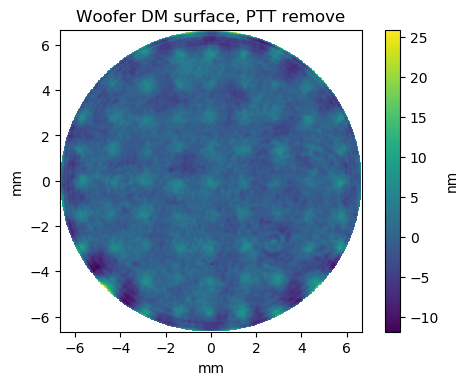

In [4]:
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'label': 'woofer',
             'surf_units': u.micron,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

wfdm_raw = fits.open('zygo_data/DM/woofer_flat.fits')[0].data * opt_parms['surf_units']
wfdm_pixscl = (0.0261627907 * u.mm).to(u.m)/u.pix

# resize the matrix. Zygo does weird things with size of data.
# numbers and sides determined from probing, already deleted.
wfdm = wfdm_raw[2:wfdm_raw.shape[0]-3, 1:wfdm_raw.shape[1]]

# make a mask
cen = int(wfdm.shape[0]/2)
yy, xx = np.mgrid[-cen:cen+1, -cen:cen+1]
mask = (yy**2 + xx**2 <= cen**2)

# aply mask to wfdm
wfdm = wfdm*mask

# show surface
dfx.show_image(data=dfx.sn_map((wfdm.to(u.nm)).value, mask),
               data_unit=u.nm,
               pixscale=(wfdm_pixscl*u.pix).to(u.mm),
               fig_title='Woofer DM surface, PTT remove')

In [5]:
%%time
# now calculate the PSD
woofer = psd.surfPSD(surf_name='woofer DM')
woofer.load_surf(data=wfdm, wavelen=632e-9*u.m, 
                 latres=wfdm_pixscl)
woofer.load_mask(mask=mask)
woofer.calc_psd(oversamp=4096)
woofer.calc_psd_radial(ring_width=opt_parms['ring_width'], 
                       kmin=woofer.k_min)

CPU times: user 2min 26s, sys: 54.7 s, total: 3min 21s
Wall time: 3min 20s


Text(0, 0.5, 'Power Spectrum [$nm^{2}$$m^{2}$]')

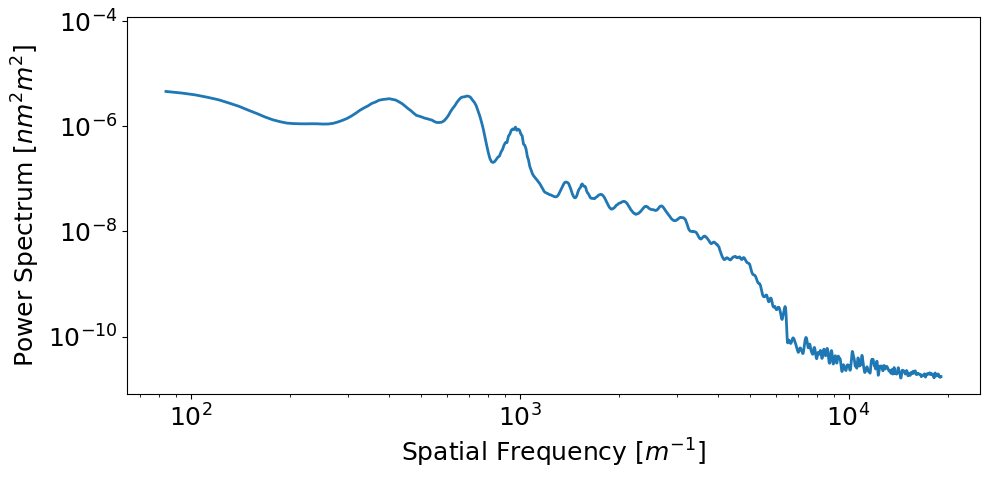

In [6]:
ylim = [1e-4, 1e-11]
xlim = [5, 5e5]

k_radial = woofer.k_radial.value
psd_radial = woofer.psd_radial_cal.value

matplotlib.rcParams["font.size"]=18
plt.figure(figsize=[11,5], dpi=100)
plt.loglog(k_radial, psd_radial, linewidth=2)
plt.ylim(top=ylim[0]*1.2, bottom=ylim[1]*0.8)
#plt.xlim(left=xlim[0]*0.8, right=xlim[1]*1.2)
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))

In [7]:
# save the radial data
psd_dict = {'k_radial': woofer.k_radial,
            'psd_radial': woofer.psd_radial_cal,
            'rms_tot': woofer.rms_tot,
            'var': 0*u.nm**2,
            'diam_ca': woofer.diam_ca,
            'npix_diam': woofer.npix_diam,
            'oversamp': woofer.oversamp,
            'delta_k': woofer.delta_k,
            'k_min': woofer.k_min,
            'k_max': woofer.k_max,
            'ring_width': opt_parms['ring_width']}

psd.psd_radial_to_fits(psd_dict=psd_dict, opt_name=opt_parms['label'],
                       fits_filename='radial/psd_{0}.fits'.format(opt_parms['label']))